In [15]:
import os
import praw
from pprint import pprint
import codecs
import glob
import re
import itertools
import numpy as np
from scipy import sparse
import pandas as pd
from copy import deepcopy
flatten = lambda l: [item for sublist in l for item in sublist]

# nltk
import nltk; nltk.download('stopwords'); nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
np.random.seed(42)

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.matutils import corpus2csc
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import Phrases
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.models import LdaModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, classification_report, balanced_accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier 
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings(action='once')

C:\Users\znf18xfu\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\znf18xfu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\znf18xfu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
### Define stopwords
# Reddit stopwords for initial removal (prior to ngramming)
reddit_stopwords = ['subject','subjects','submission','submissions','submit',
                    'reddit','subreddit','report',
                    'http','https','www','com','re','edu',
                    'post','moderator','moderators','wiki',
                    'comment','comments','button','downvote','upvote','thread','threads','guidelines',
                    'wikipedia','delete','link','links','remove','removed',
                    'politicaldiscussion', 'automatic','automatically','message','messages'
]

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Add gensim stopwords
stop_words.extend(gensim.parsing.preprocessing.STOPWORDS)

# Manually added stopwords
stop_words.extend(['from', 'subject', 'subjects','re', 'edu', 'use','submission','submissions','submit',
                    'reddit','subreddit','report',
                    'http','https','www','com',
                    'post','moderator','moderators','wiki',
                    'comment','comments','button','downvote','upvote','thread','threads','guidelines',
                    'wikipedia','delete','link','links','remove','removed',
                    'politicaldiscussion',])

stop_words = frozenset(stop_words)

C:\Users\znf18xfu\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# Functions

def remove_reddit_stopwords(text):
    return [word for word in text if \
    not any([re.search(stopword,word) for stopword in reddit_stopwords])]

def remove_stopwords(text):
    return [word for word in text if word not in stop_words] 

# Test LDA coherence values for multiple topic numbers
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        model = LdaModel(corpus=bow_corpus,id2word=id2word,chunksize=chunksize,
        alpha='auto',eta='auto',iterations=iterations,num_topics=num_topics,
        passes=passes,eval_every=eval_every)

        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(12, 10))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=18)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",size=25)

    plt.ylabel('True label',fontsize=25)
    plt.xlabel('Predicted label',fontsize=25)

class CommentsCorpus:
    def __init__(self,input_df = None, input_dir=None,label=None, limit=None):
        # Use either input_dir to load from file or input_df if df exists
        if input_dir is not None:
            # Get dir and label
            root_dir = os.getcwd()
            full_input_dir = os.path.join(root_dir,input_dir)
            print('Initializing corpus from directory {}'.format(full_input_dir))
            os.chdir(full_input_dir)

            # Initialize DF
            self.corpus = pd.DataFrame()

            # Initialize holders for files and
            self._txtfiles = []; 
            self._texts = []
            #self._jsons = []
            file_counter = 1

            # Load relevant data
            for file_ in glob.glob("*[a-zA-Z0-9].utf8"):
                self._txtfiles.append(file_)

                current_filename = codecs.open(file_,'r','utf-8')
                raw = current_filename.read()
                current_filename.close()
                self._texts.append(raw)

                file_counter += 1

                if limit is not None:
                    if file_counter > limit:
                        break
        
            self.corpus['texts'] = self._texts
            self.corpus['labels'] = label

            os.chdir(root_dir)
        elif input_df is not None:
            self.corpus = input_df

        # Just initializing these here to be sure they exist for later
        self.lda_models_ = []; self.lda_perplexities_ = []; self.lda_coherences_ = [];
        self.embedding_model_ = []; 
        self.classifications = {
            'classifier': [],
            'accuracy': [],
            'std': []
        }

    def __add__(self,other):
        # For adding corpora together 
        # Won't replace derived instance attributes. Must make them again
        # Probably best to do at an early stage in processing
        conjoined_df = pd.concat([self.corpus,other.corpus],ignore_index=True)
        return CommentsCorpus(input_df=conjoined_df)
    
    def subsample(self,group_label=None,n_sample=1000):
        if group_label:
            subsample_df = deepcopy(self.corpus[self.corpus['labels']==group_label])
        else:
            subsample_df = deepcopy(self.corpus)

        out_subsample_df = subsample_df.sample(n=n_sample,replace=False)

        return CommentsCorpus(input_df=out_subsample_df)

    def balance_corpus(self,n_sample=None):
        if n_sample is None:
            # Find smallest class (doesn't matter if two are equally small)
            class_counts = self.corpus.groupby(by='labels').count()
            smallest_class = class_counts.idxmin().values[0]
            n_sample = class_counts.loc[smallest_class].values[0]
            print("nsample is",n_sample)

        smallest_label = min(set(self.corpus['labels']))

        for label in set(self.corpus['labels']):
            if label == smallest_label:
                output_corpus = self.subsample(group_label=label,n_sample=n_sample)
            else:
                current_subcorpus = self.subsample(group_label=label,n_sample=n_sample)
                output_corpus = output_corpus + current_subcorpus
        
        return output_corpus
    
    def filter_short_texts(self,filter_size):
        self.corpus = self.corpus[ self.corpus['texts'].str.len() > filter_size]
    
    def tokenize(self,tokenizer):
        self.corpus['tokenized'] = self.corpus['texts'].map(lambda text: text.lower()) # lowercase text
        self.corpus['tokenized'] = self.corpus['tokenized'].map(lambda text: tokenizer.tokenize(text))
        self.corpus['nwords'] = self.corpus['tokenized'].map(lambda text: len(text))

    def clean_tokens(self,remove_nums=True,remove_nchars=False,remove_stops=True):
        if remove_nums:
            self.corpus['tokenized'] = self.corpus['tokenized'].apply(
                lambda text: [token for token in text if not token.isnumeric()]
                )
        if remove_nchars:
            self.corpus['tokenized'] = self.corpus['tokenized'].apply(
                lambda text: [token for token in text if len(token) > remove_nchars]
            )
        if remove_stops:
            self.corpus['tokenized'] = self.corpus['tokenized'].apply(remove_reddit_stopwords)

    def lemmatize(self,lemmatizer):
        self.corpus['lemmatized'] = self.corpus['tokenized'].apply(
            lambda text: [lemmatizer.lemmatize(token) for token in text]
        )
    
    def doc2vec_model(self,column='tokenized',vector_size=50,
                      workers=6, epochs=20,
                      save_doc2vec=False,fname="temp_embedding_model"):
        self.corpus['tagged'] = [
            TaggedDocument(words, ['d{}'.format(idx)])
            for idx, words in enumerate(self.corpus[column])
            ]
        self.embedding_model_ = Doc2Vec(self.corpus['tagged'], vector_size=vector_size, workers=workers, epochs=epochs, min_count=2)
        self.corpus['embedding_vector'] = [
            self.embedding_model_.docvecs[idx] for idx in 
            range(len(self.embedding_model_.docvecs))
        ]

        # Optionally save model to file
        if save_doc2vec:
            from gensim.test.utils import get_tmpfile
            fname = get_tmpfile(fname)
            self.embedding_model_.save(fname)
        
        self.embedding_model_.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    def feature_union(self,out_column,column_1,column_2):
        for x in self.corpus.index:
            self.corpus[out_column].loc[x] = np.concatenate((self.corpus[column_1].loc[x],self.corpus[column_2].loc[x]))

    def make_bigrams(self,min_count=20,threshold=20):
        # Initialize bigram list
        # Have to use apply or loop because the elements to be copied are lists
        # df.copy will produce shallow copies of the elements if the elements are \
        # lists even if the dfs are different...

        self.corpus['with_bigrams'] = self.corpus['lemmatized'].apply(deepcopy)

        self.bigram = Phrases(self.corpus['with_bigrams'], min_count=min_count,threshold=threshold)
        self.bigram_model = gensim.models.phrases.Phraser(self.bigram)
        
        self.corpus['with_bigrams'].apply(
            lambda text: [ text.append(token) for token in self.bigram_model[text] \
                if '_' in token  ]
        )
    
    def make_trigrams(self,min_count=20,threshold=20):
        # Initialize trigram list
        self.corpus['with_trigrams'] = self.corpus['with_bigrams'].apply(deepcopy)

        self.trigram = Phrases(self.bigram[self.corpus['with_trigrams']], min_count=min_count,threshold=threshold)
        self.trigram_model = gensim.models.phrases.Phraser(self.trigram)
        
        self.corpus['with_trigrams'].apply(
            lambda text: [ text.append(token) for token in self.trigram_model[self.bigram_model[text]] \
                if ('_' in token and token not in text) ]
        )

    def filter_stopwords(self,stop_words,column):
        self.corpus[column] = self.corpus[column].apply(
            lambda text: remove_stopwords(text)
        )

    def filter_short_words(self,column,nchars=2):
        self.corpus[column] = self.corpus[column].apply(
            lambda text: [word for word in text if len(word) > nchars]
        )
    
    def make_nltk_text(self,column,group=None):
        if group==None:
            self.nlkt_text = nltk.Text(flatten(self.corpus[column]))
        else:
            self.nlkt_text = nltk.Text(flatten(self.corpus[column][self.corpus['labels']==group]))

    
    def get_freqdist(self,nwords=100,plot=True,n=100):
        freqdist = nltk.FreqDist(self.nlkt_text)
        pprint(freqdist.most_common(nwords))
        freqdist.plot(n,cumulative=False)
        plt.show()
        return freqdist
    
    def plot_nwords(self,nbins=50,density=False,color='b'):
        fig, ax = plt.subplots()
        mu = np.nanmean(self.corpus['nwords'])
        sigma = np.nanstd(self.corpus['nwords'])

        n, bins, patches = ax.hist(self.corpus['nwords'], nbins, density=density)

        # add a 'best fit' line
        y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
            np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
        ax.plot(bins, y, '--')
        ax.set_xlabel('Number of Words per Text')
        if density:
            ax.set_ylabel('Probability density')
        else:
            ax.set_ylabel('Frequency')

        ax.set_title(r'Histogram of Word Frequencies')

        # Tweak spacing to prevent clipping of ylabel
        fig.tight_layout()
        plt.show()
        return fig, ax
    
    def drop_nwords(self,n):
        self.corpus = self.corpus[self.corpus['nwords'] >= n]
        return

    def train_test_split(self,test_ratio=(1/3),random_state=42):
        # Just wraps sklearn shuffle-split
        # Could do something more sophisticated if need be
        X_train, X_test, y_train, y_test = train_test_split(
            self.corpus[self.corpus.columns.difference(['labels'])], self.corpus['labels'],
            test_size=test_ratio, random_state=42)
        
        train_data = pd.concat([X_train, y_train], axis=1)
        test_data = pd.concat([X_test, y_test], axis=1)

        # Return train and test data as Political Corpuses
        train_corpus = CommentsCorpus(input_df=train_data)
        test_corpus = CommentsCorpus(input_df=test_data)

        return train_corpus, test_corpus
    
    def make_dictionary(self,column):
        self.dictionary = gensim.corpora.Dictionary(self.corpus[column])
        print('Number of unique tokens: %d' % len(self.dictionary))
    
    def make_bow(self,column):
        self.corpus['bow'] = self.corpus[column].apply(
            lambda text: self.dictionary.doc2bow(text)
        )
        self.corpus['bow_sparse'] = corpus2csc(self.corpus['bow'],self.dictionary.num_pos)
        print('Number of documents in bow: %d' % len(self.corpus['bow']))
    
    def make_tfidf(self):
        tfidf = TfidfModel(self.corpus['bow'].values.tolist())
        self.corpus['tfidf'] = tfidf[self.corpus['bow'].values.tolist()]
        self.corpus['tfidf_sparse'] = corpus2csc(self.corpus['tfidf'],self.dictionary.num_pos)
    
    def LDA(self,num_topics,bow_column='bow',texts_column='with_trigrams',
                chunksize=2000,passes=50,iterations=1000,eta=None,
                eval_every=False,workers=6,dtype=np.float64):
        
        # Just wraps gensim's LDA as an instance method
        # Then prints perplexity and coherence
        # Maybe this should just be a separate function
        self.lda_model_ = gensim.models.LdaMulticore(num_topics=num_topics, 
                                    corpus=self.corpus[bow_column],
                                    id2word=self.dictionary,
                                    chunksize=chunksize,
                                    passes=passes,
                                    iterations=iterations,
                                    eta=eta,
                                    eval_every=eval_every,
                                    workers=6,
                                    dtype=np.float64)
        # Print topics
        for idx, topic in self.lda_model_.print_topics(-1):
            print("Topic: {} \nWords: {}".format(idx, topic ))
            print("\n")
        
        # Compute Perplexity Score
        self.lda_model_perplexity_ = self.lda_model_.log_perplexity(self.corpus[bow_column])
        print('\nPerplexity: ', self.lda_model_perplexity_)  # a measure of how good the model is. lower the better.

        # Compute Coherence Score
        self.coherence_model_lda_ = CoherenceModel(model=self.lda_model_, 
                                        texts=self.corpus[texts_column], 
                                        dictionary=self.dictionary, 
                                        coherence='c_v')

        self.lda_model_coherence_ = self.coherence_model_lda_.get_coherence()
        print('\nCoherence Score: ', self.lda_model_coherence_)

    def make_LDA_vectors(self,column='bow'):
        # Column is probably bow (hence the variable names used below)...
        # But maybe could use tf-idf or something else here
        # Should be input used to generate LDA, obiviously

        def get_lda_vector(input):
            _, lda_vector = zip(*self.lda_model_.get_document_topics(
                input, minimum_probability=0.0))
            return np.array(lda_vector)

        self.corpus['lda_vector'] = self.corpus[column].apply(get_lda_vector)


        for bow_index, bow_data in self.corpus[column].iteritems():
            _, lda_vector = zip(*self.lda_model_.get_document_topics(
                bow_data,minimum_probability=0.0)
            )
            self.corpus['lda_vector'][bow_index]=np.array(lda_vector)


    def classify(self,column,clf,cv=3,confusion=False,labels=[],n_jobs=6,verbose=1):
        if column == 'lda_vector':
            X = np.vstack(self.corpus[column])
        elif (column == 'bow' or column == 'tfidf'):
            X = corpus2csc(self.corpus[column],self.dictionary.num_pos).T
        elif column == 'union':
            X = pd.DataFrame(self.corpus['texts'])
            X = pd.concat([X,pd.DataFrame(np.vstack(self.corpus['lda_vector']))],axis=1)
        else:
            X = self.corpus[column]
        y = self.corpus['labels']
        cv_output = cross_val_score(clf,X,y,cv=cv,n_jobs=n_jobs,verbose=verbose)
        
        self.classifications['classifier'].append(clf)
        self.classifications['accuracy'].append(np.mean(cv_output))
        self.classifications['std'].append(np.std(cv_output))
        print("Classification accuracy is {}".format(str(np.nanmean(self.classifications['accuracy']))))
        
        cv_predictions = cross_val_predict(clf,X,y, groups=None, cv=cv,n_jobs=n_jobs,verbose=verbose)

        if confusion:
            cfn_mtx = confusion_matrix(y,cv_predictions)
            plt.figure(figsize=[12,10])
            plot_confusion_matrix(cfn_mtx, classes=labels,normalize=True,title='Confusion matrix')
        
        return cv_output, cv_predictions
    
    def classify_by_ntopics(self,classifier,start=2,limit=100,lda_column='bow',classifier_column='lda_vector',cv=3,labels=[],n_jobs=6,verbose=1):
        # First reset lists associated with each model
        self.lda_models_ = [];  self.lda_perplexities_ = []; self.lda_coherences_ = []
        self.classifications['classifier'] = []; self.classifications['accuracy'] = []
        self.classifications['std'] = []
        
        # Iterate through with each number of topics
        for current_topic_num in range(start,limit):
            self.LDA(current_topic_num,bow_column=lda_column)
            self.lda_models_.append(self.lda_model_)
            self.lda_perplexities_.append(self.lda_model_perplexity_)
            self.lda_coherences_.append(self.lda_model_coherence_)

            self.make_LDA_vectors(column=lda_column)

            cv_outputs, cv_results = self.classify(column=classifier_column,
                            clf=classifier,
                            cv=cv,confusion=False,
                            labels=labels,n_jobs=n_jobs,verbose=verbose)
            
        fig, ax = plt.subplots(figsize=[12,10])
        ax.plot(range(start,limit), self.classifications['accuracy'], color='b',
                label=r'Mean Accuracy',lw=2, alpha=.8)
            
        stds = np.array(self.classifications['std'])
        accuracies = np.array(self.classifications['accuracy'])
        tprs_upper = np.minimum(accuracies + stds, 1)
        tprs_lower = np.maximum(accuracies - stds, 0)
        ax.fill_between(range(start,limit), tprs_lower, tprs_upper, color='grey', alpha=.2,
            label=r'$\pm$ 1 std. dev.')
        ax.legend(loc="lower right")
        plt.show()

        return fig, ax
    
    def plot_learning_curves(self,column,clf,labels=None): # from Aurelien Geron
        X = np.vstack(self.corpus[column])
        y = train_corpus.corpus['labels']
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,shuffle=True)
        train_errors, val_errors = [], []

        for m in range(2,len(X_train)):
            clf.fit(X_train[:m], y_train[:m])
            y_train_predict = clf.predict(X_train[:m])
            y_val_predict = clf.predict(X_val)
            train_errors.append(accuracy_score(y_train_predict, y_train[:m]))
            val_errors.append(accuracy_score(y_val_predict, y_val))
            print('Model score is ' + str(clf.score(X_val,y_val)))
            print('Train error is ' + str(np.nanmean(train_errors)))
            print('Test error is ' + str(np.nanmean(val_errors)))
            print(classification_report(y_val, y_val_predict,target_names=labels))

        plt.plot(train_errors, "r-+", linewidth=2, label="train")
        plt.plot(val_errors, "b-", linewidth=3, label="val")


def eval_coherence(topics_dict, word_list, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_model function
    word_list: list -> lemmatized word list of lists
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    score: float -> coherence value
    '''
    
    # Build gensim objects
    vocab = corpora.Dictionary(word_list)
    corpus = [vocab.doc2bow(words) for words in word_list]
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)
            
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    print("Evaluating topic coherence...")
    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list, 
                    coherence=coherence_type)
    
    score = cm.get_coherence()
    print ("Done\n")
    return score	

In [18]:
#### Trial analysis flow
ana_corpus = CommentsCorpus(input_dir='pol_anarchism',label=1,limit=100000)
soc_corpus = CommentsCorpus(input_dir='pol_socialism',label=2,limit=100000)
dem_corpus = CommentsCorpus(input_dir='pol_democrats',label=3,limit=100000)
libs_corpus = CommentsCorpus(input_dir='pol_liberal',label=4,limit=100000)
con_corpus = CommentsCorpus(input_dir='pol_conservative',label=5,limit=100000)
rep_corpus = CommentsCorpus(input_dir='pol_republican',label=6,limit=100000)
libertarian_corpus = CommentsCorpus(input_dir='pol_libertarian',label=7,limit=100000)


full_corpus = ana_corpus + soc_corpus + dem_corpus + libs_corpus + con_corpus + rep_corpus + libertarian_corpus # aggregate corpora

train_corpus, test_corpus = full_corpus.train_test_split()

Initializing corpus from directory C:\Studies\Reddit\pol_anarchism
Initializing corpus from directory C:\Studies\Reddit\pol_socialism
Initializing corpus from directory C:\Studies\Reddit\pol_democrats
Initializing corpus from directory C:\Studies\Reddit\pol_liberal
Initializing corpus from directory C:\Studies\Reddit\pol_conservative
Initializing corpus from directory C:\Studies\Reddit\pol_republican
Initializing corpus from directory C:\Studies\Reddit\pol_libertarian


In [19]:
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

# Drop short text by n chars
train_corpus.filter_short_texts(200)

# Tokenize, clean and filter
train_corpus.tokenize(tokenizer)
train_corpus.clean_tokens(remove_nums=True,remove_nchars=1,remove_stops=True)
train_corpus.filter_short_words('tokenized',nchars=3)
train_corpus.filter_stopwords(stop_words,'tokenized')
train_corpus.lemmatize(lemmatizer)

# Drop texts with small or large number of words 
train_corpus.drop_nwords(20)
train_corpus.corpus = train_corpus.corpus[train_corpus.corpus['nwords'] < 1000]

train_corpus.make_bigrams(threshold=1)

# Balance texts by label
balanced_train_corpus = train_corpus.balance_corpus()

balanced_train_corpus.make_dictionary('with_bigrams')
balanced_train_corpus.dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
balanced_train_corpus.make_bow('with_bigrams')
balanced_train_corpus.make_tfidf()

nsample is 13210
Number of unique tokens: 66311
Number of documents in bow: 92470


C:\Users\znf18xfu\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


C:\Users\znf18xfu\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


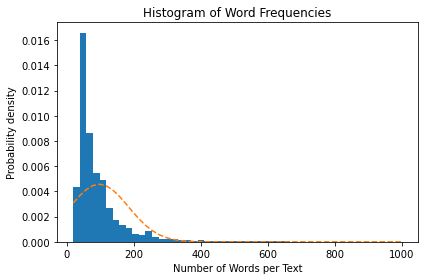

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Histogram of Word Frequencies'}, xlabel='Number of Words per Text', ylabel='Probability density'>)

In [20]:
# Count and plot
balanced_train_corpus.corpus.groupby('labels').count() 
balanced_train_corpus.plot_nwords(nbins=50,density=True,color='b')


C:\Users\znf18xfu\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('people', 45364),
 ('like', 28730),
 ('think', 21511),
 ('right', 20149),
 ('trump', 19272),
 ('want', 16214),
 ('thing', 15477),
 ('state', 14882),
 ('vote', 14509),
 ('time', 13583),
 ('socialism', 13455),
 ('know', 12926),
 ('question', 12218),
 ('need', 12062),
 ('government', 11956),
 ('work', 11803),
 ('year', 10950),
 ('mean', 10822),
 ('party', 10738),
 ('country', 10546),
 ('good', 10540),
 ('democrat', 10465),
 ('point', 9712),
 ('going', 9587),
 ('action', 9437),
 ('issue', 9373),
 ('said', 8694),
 ('socialist', 8526),
 ('left', 8203),
 ('actually', 7856),
 ('money', 7720),
 ('election', 7474),
 ('concern', 7255),
 ('place', 7233),
 ('life', 7186),
 ('believe', 7157),
 ('perspective', 7028),
 ('american', 7007),
 ('world', 6885),
 ('contact', 6866),
 ('fact', 6639),
 ('better', 6586),
 ('liberal', 6542),
 ('performed', 6505),
 ('problem', 6459),
 ('political', 6435),
 ('support', 6402),
 ('power', 6362),
 ('conservative', 6338),
 ('view', 6221),
 ('class', 6218),
 ('societ

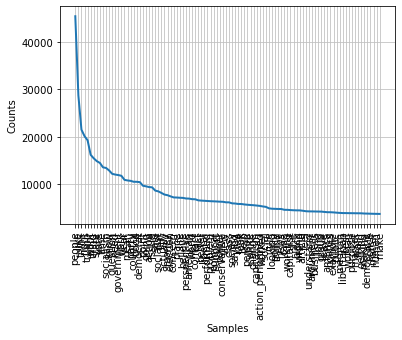

FreqDist({'people': 45364, 'like': 28730, 'think': 21511, 'right': 20149, 'trump': 19272, 'want': 16214, 'thing': 15477, 'state': 14882, 'vote': 14509, 'time': 13583, ...})

In [21]:
balanced_train_corpus.make_nltk_text('with_bigrams')
balanced_train_corpus.get_freqdist(nwords=100,n=100)

In [22]:
# LDA topic model
balanced_train_corpus.LDA(20,texts_column='with_bigrams')
balanced_train_corpus.make_LDA_vectors('bow')

Topic: 0 
Words: 0.198*"issue" + 0.097*"purpose" + 0.085*"partisan" + 0.080*"imgur" + 0.077*"subvert" + 0.076*"discus_issue" + 0.017*"identity" + 0.014*"gender" + 0.006*"facing" + 0.006*"main"


Topic: 1 
Words: 0.055*"government" + 0.034*"libertarian" + 0.017*"private" + 0.017*"property" + 0.014*"human" + 0.013*"society" + 0.011*"individual" + 0.011*"state" + 0.010*"believe" + 0.009*"idea"


Topic: 2 
Words: 0.033*"year" + 0.032*"obama" + 0.013*"house" + 0.013*"campaign" + 0.012*"html" + 0.011*"news" + 0.011*"climate" + 0.011*"administration" + 0.010*"politics" + 0.010*"donald"


Topic: 3 
Words: 0.039*"country" + 0.018*"world" + 0.016*"china" + 0.015*"military" + 0.013*"nation" + 0.013*"american" + 0.010*"america" + 0.010*"state" + 0.009*"government" + 0.009*"million"


Topic: 4 
Words: 0.070*"perspective" + 0.061*"vote" + 0.053*"action" + 0.053*"concern" + 0.050*"contact" + 0.048*"performed" + 0.044*"action_performed" + 0.036*"discus" + 0.036*"leave" + 0.036*"contact_question"


Top

C:\Users\znf18xfu\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
vis = pyLDAvis.gensim.prepare(balanced_train_corpus.lda_model_, balanced_train_corpus.corpus['bow'], balanced_train_corpus.dictionary)
pyLDAvis.display(vis)

In [24]:
# LDA topic model with 50 topics
balanced_train_corpus.LDA(50,texts_column='with_bigrams')
balanced_train_corpus.make_LDA_vectors('bow')

C:\Users\znf18xfu\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic: 0 
Words: 0.058*"socialism" + 0.020*"debate" + 0.020*"search" + 0.017*"equal" + 0.017*"rule" + 0.012*"sub" + 0.011*"enforced" + 0.010*"patient" + 0.010*"strictly" + 0.010*"friendly"


Topic: 1 
Words: 0.070*"woman" + 0.027*"friend" + 0.022*"family" + 0.019*"young" + 0.019*"supporter" + 0.019*"gender" + 0.016*"best" + 0.013*"male" + 0.011*"trump_supporter" + 0.011*"girl"


Topic: 2 
Words: 0.445*"main_purpose" + 0.110*"knowledge" + 0.043*"seeking" + 0.027*"update" + 0.018*"brief" + 0.017*"participant" + 0.016*"trafficking" + 0.016*"ring" + 0.016*"contest" + 0.014*"visiting"


Topic: 3 
Words: 0.029*"attention" + 0.027*"image" + 0.022*"flag" + 0.013*"biased" + 0.012*"brother" + 0.012*"letter" + 0.012*"veteran" + 0.011*"accusation" + 0.009*"deep" + 0.009*"send"


Topic: 4 
Words: 0.072*"live" + 0.035*"poor" + 0.024*"life" + 0.017*"muslim" + 0.015*"dead" + 0.014*"exact" + 0.013*"lot" + 0.013*"world" + 0.009*"country" + 0.009*"poor_people"


Topic: 5 
Words: 0.030*"gun" + 0.023*"law"


Perplexity:  -9.183492539501191

Coherence Score:  0.5121814437415976


C:\Users\znf18xfu\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
vis = pyLDAvis.gensim.prepare(balanced_train_corpus.lda_model_, balanced_train_corpus.corpus['bow'], balanced_train_corpus.dictionary)
pyLDAvis.display(vis)